# A Review of Histogram Equalization Techniques in Image Enhancement Application 

## 1 Fundamental Histogram Equalization Algorithm

In [2]:
import matplotlib.pyplot as plt
import numpy as np
import cv2

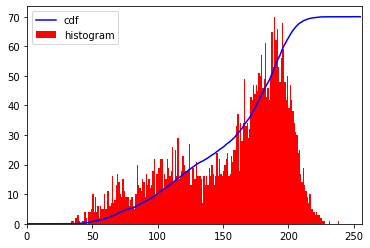

In [60]:
img = cv2.imread('./images/0005_gt.png', 0) # Using 0 to read image in grayscale mode 
hist, bins = np.histogram(img.flatten(), 256, [0, 256])

cdf = hist.cumsum()
cdf_normalized = cdf * hist.max() / cdf.max()

plt.plot(cdf_normalized, color='b')
plt.hist(img.flatten(), 256, [0,256], color='r')
plt.xlim([0,256])
plt.legend(('cdf', 'histogram'), loc='upper left')
plt.show()

Text(0.5, 1.0, "'Original' 'EH'")

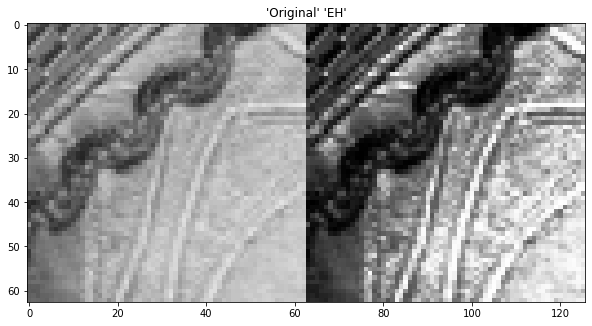

In [61]:
cdf_m = np.ma.masked_equal(cdf, 0)
cdf_m = (cdf_m - cdf_m.min())*255 / (cdf_m.max() - cdf_m.min())
cdf = np.ma.filled(cdf_m, 0).astype('uint8')

img2 = cdf[img]
res = np.hstack((img, img2))
plt.figure(figsize=(10,10))
plt.imshow(res, cmap="gray")
plt.title("'Original' 'EH'")

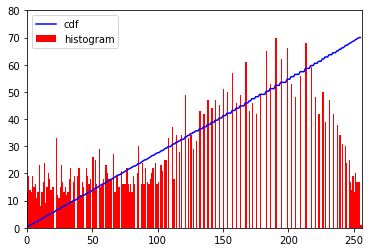

In [64]:
hist, bins = np.histogram(img2.flatten(), 256, [0, 256])

cdf = hist.cumsum()
cdf_normalized = cdf * hist.max() / cdf.max()

plt.plot(cdf_normalized, color='b')
plt.hist(img2.flatten(), 256, [0, 256], color='r')
plt.xlim([0, 256])
plt.ylim([0, 80])
plt.legend(('cdf', 'histogram'), loc='upper left')
plt.show()

**Implemented with OpenCV**

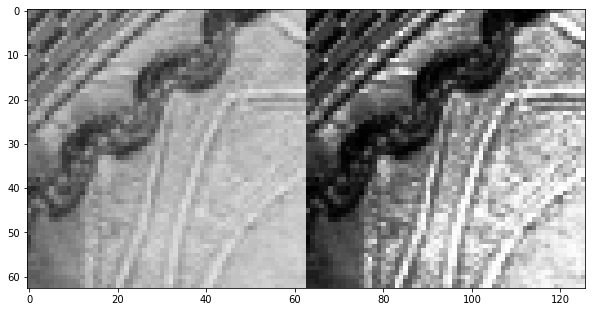

In [69]:
img = cv2.imread('./images/0005_gt.png', 0)
equ = cv2.equalizeHist(img)
res = np.hstack((img,equ))
cv2.imwrite('./images/res.png', res)

plt.figure(figsize=(10,10))
plt.imshow(res, cmap='gray')

**Implemented with Skimage**

c:\users\dell\appdata\local\programs\python\python38\lib\site-packages\skimage\exposure\exposure.py:181: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  hist, bin_centers = histogram(image, nbins)


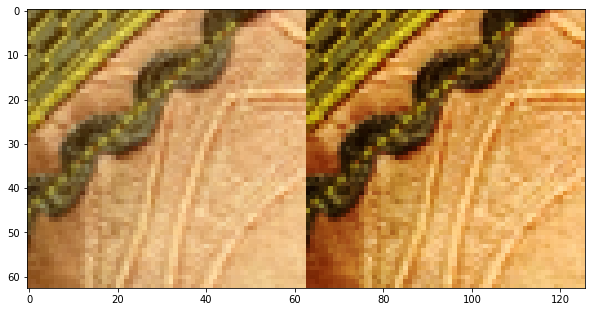

In [70]:
from skimage import data, img_as_float
from skimage import exposure

img = plt.imread('./images/0005_gt.png')
img = img_as_float(img)
img_eq = exposure.exposure.equalize_hist(img)
res = np.hstack((img, img_eq))
cv2.imwrite('./images/res.png', res)

plt.figure(figsize=(10,10))
plt.imshow(res, cmap='gray')

## 2 Bi-Histogram Equalization (BBHE)

More fundamental reason behind such limitations of the histogram equalization is that the histogram equalization **does not take the mean brightness** of an image into account.

In [71]:
def BHE(img):
    
    img_mean = int(np.mean(img))
    
    img_l = img.flatten().compress((img.flatten() <= img_mean).flat)
    img_u = img.flatten().compress((img.flatten() >  img_mean).flat)
    
    hist_l, bins_l = np.histogram(img_l, img_mean+1, [0, img_mean])
    pdf_l = hist_l / np.prod(img_l.size)
    cdf_l = pdf_l.cumsum()
    
    cdf_l = cdf_l * (img_mean - img.min()) + img.min()
    
    hist_u, bins_u = np.histogram(img_u, 256-img_mean, [img_mean+1, 256])
    pdf_u = hist_u / np.prod(img_u.size)
    cdf_u = pdf_u.cumsum()
    
    cdf_u = cdf_u * (img.max() - (int(img_mean) + 1)) + (int(img_mean) + 1)
    
    cdf_new = np.concatenate((cdf_l, cdf_u))
    new_img = cdf_new[img.ravel()]
    img_eq = np.reshape(new_img, img.shape)
    
    return img_eq

Text(0.5, 1.0, "'Original'          'Fundamental Histogram Equalization'           'BBHE'")

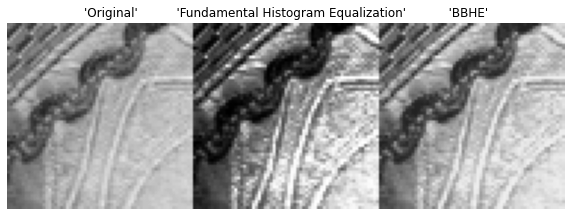

In [72]:
img = cv2.imread('./images/0005_gt.png', 0)
img_BBHE = BHE(img)
res = np.hstack((img, equ, img_BBHE))

plt.figure(figsize=(10,10))
plt.imshow(res, cmap='gray')
plt.axis('off')
plt.title("'Original'          'Fundamental Histogram Equalization'           'BBHE'")

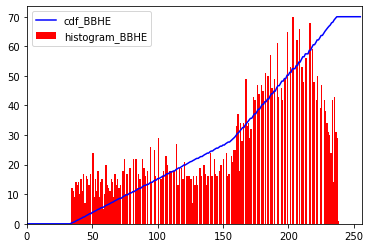

In [73]:
hist_BBHE, bins_BBHE = np.histogram(img_BBHE.flatten(), 256, [0, 256])

cdf_BBHE = hist_BBHE.cumsum()
cdf_normalized_BBHE = cdf_BBHE * hist_BBHE.max() / cdf_BBHE.max()

plt.plot(cdf_normalized_BBHE, color='b')
plt.hist(img_BBHE.flatten(), 256, [0,256], color='r')
plt.xlim([0,256])
plt.legend(('cdf_BBHE', 'histogram_BBHE'), loc='upper left')
plt.show()

**It can be found that BHE basically maintains the brightness level of the original picture, making the result of the equalization more natural, and some details in the picture will be seen more clearly than the original picture.**

## 3 Clipped Histogram Equalization